# Few-Shot Audio Classification with CLAP Embeddings

### What is Few-Shot Learning?

Few-shot learning is a machine learning approach where a model is trained using only a **small number of labeled examples per class**. This technique is useful in scenarios where labeled data is scarce or expensive to collect.

Rather than training an entire model from scratch, few-shot learning often involves:
- Leveraging a **pretrained model** to extract rich features (embeddings),
- Training a lightweight classifier (e.g., linear layer) on top of these embeddings.

This approach is especially effective when using powerful foundation models.

### What is CLAP?

**CLAP (Contrastive Language-Audio Pretraining)** is a large-scale foundation model that learns shared representations between audio and natural language using contrastive learning.

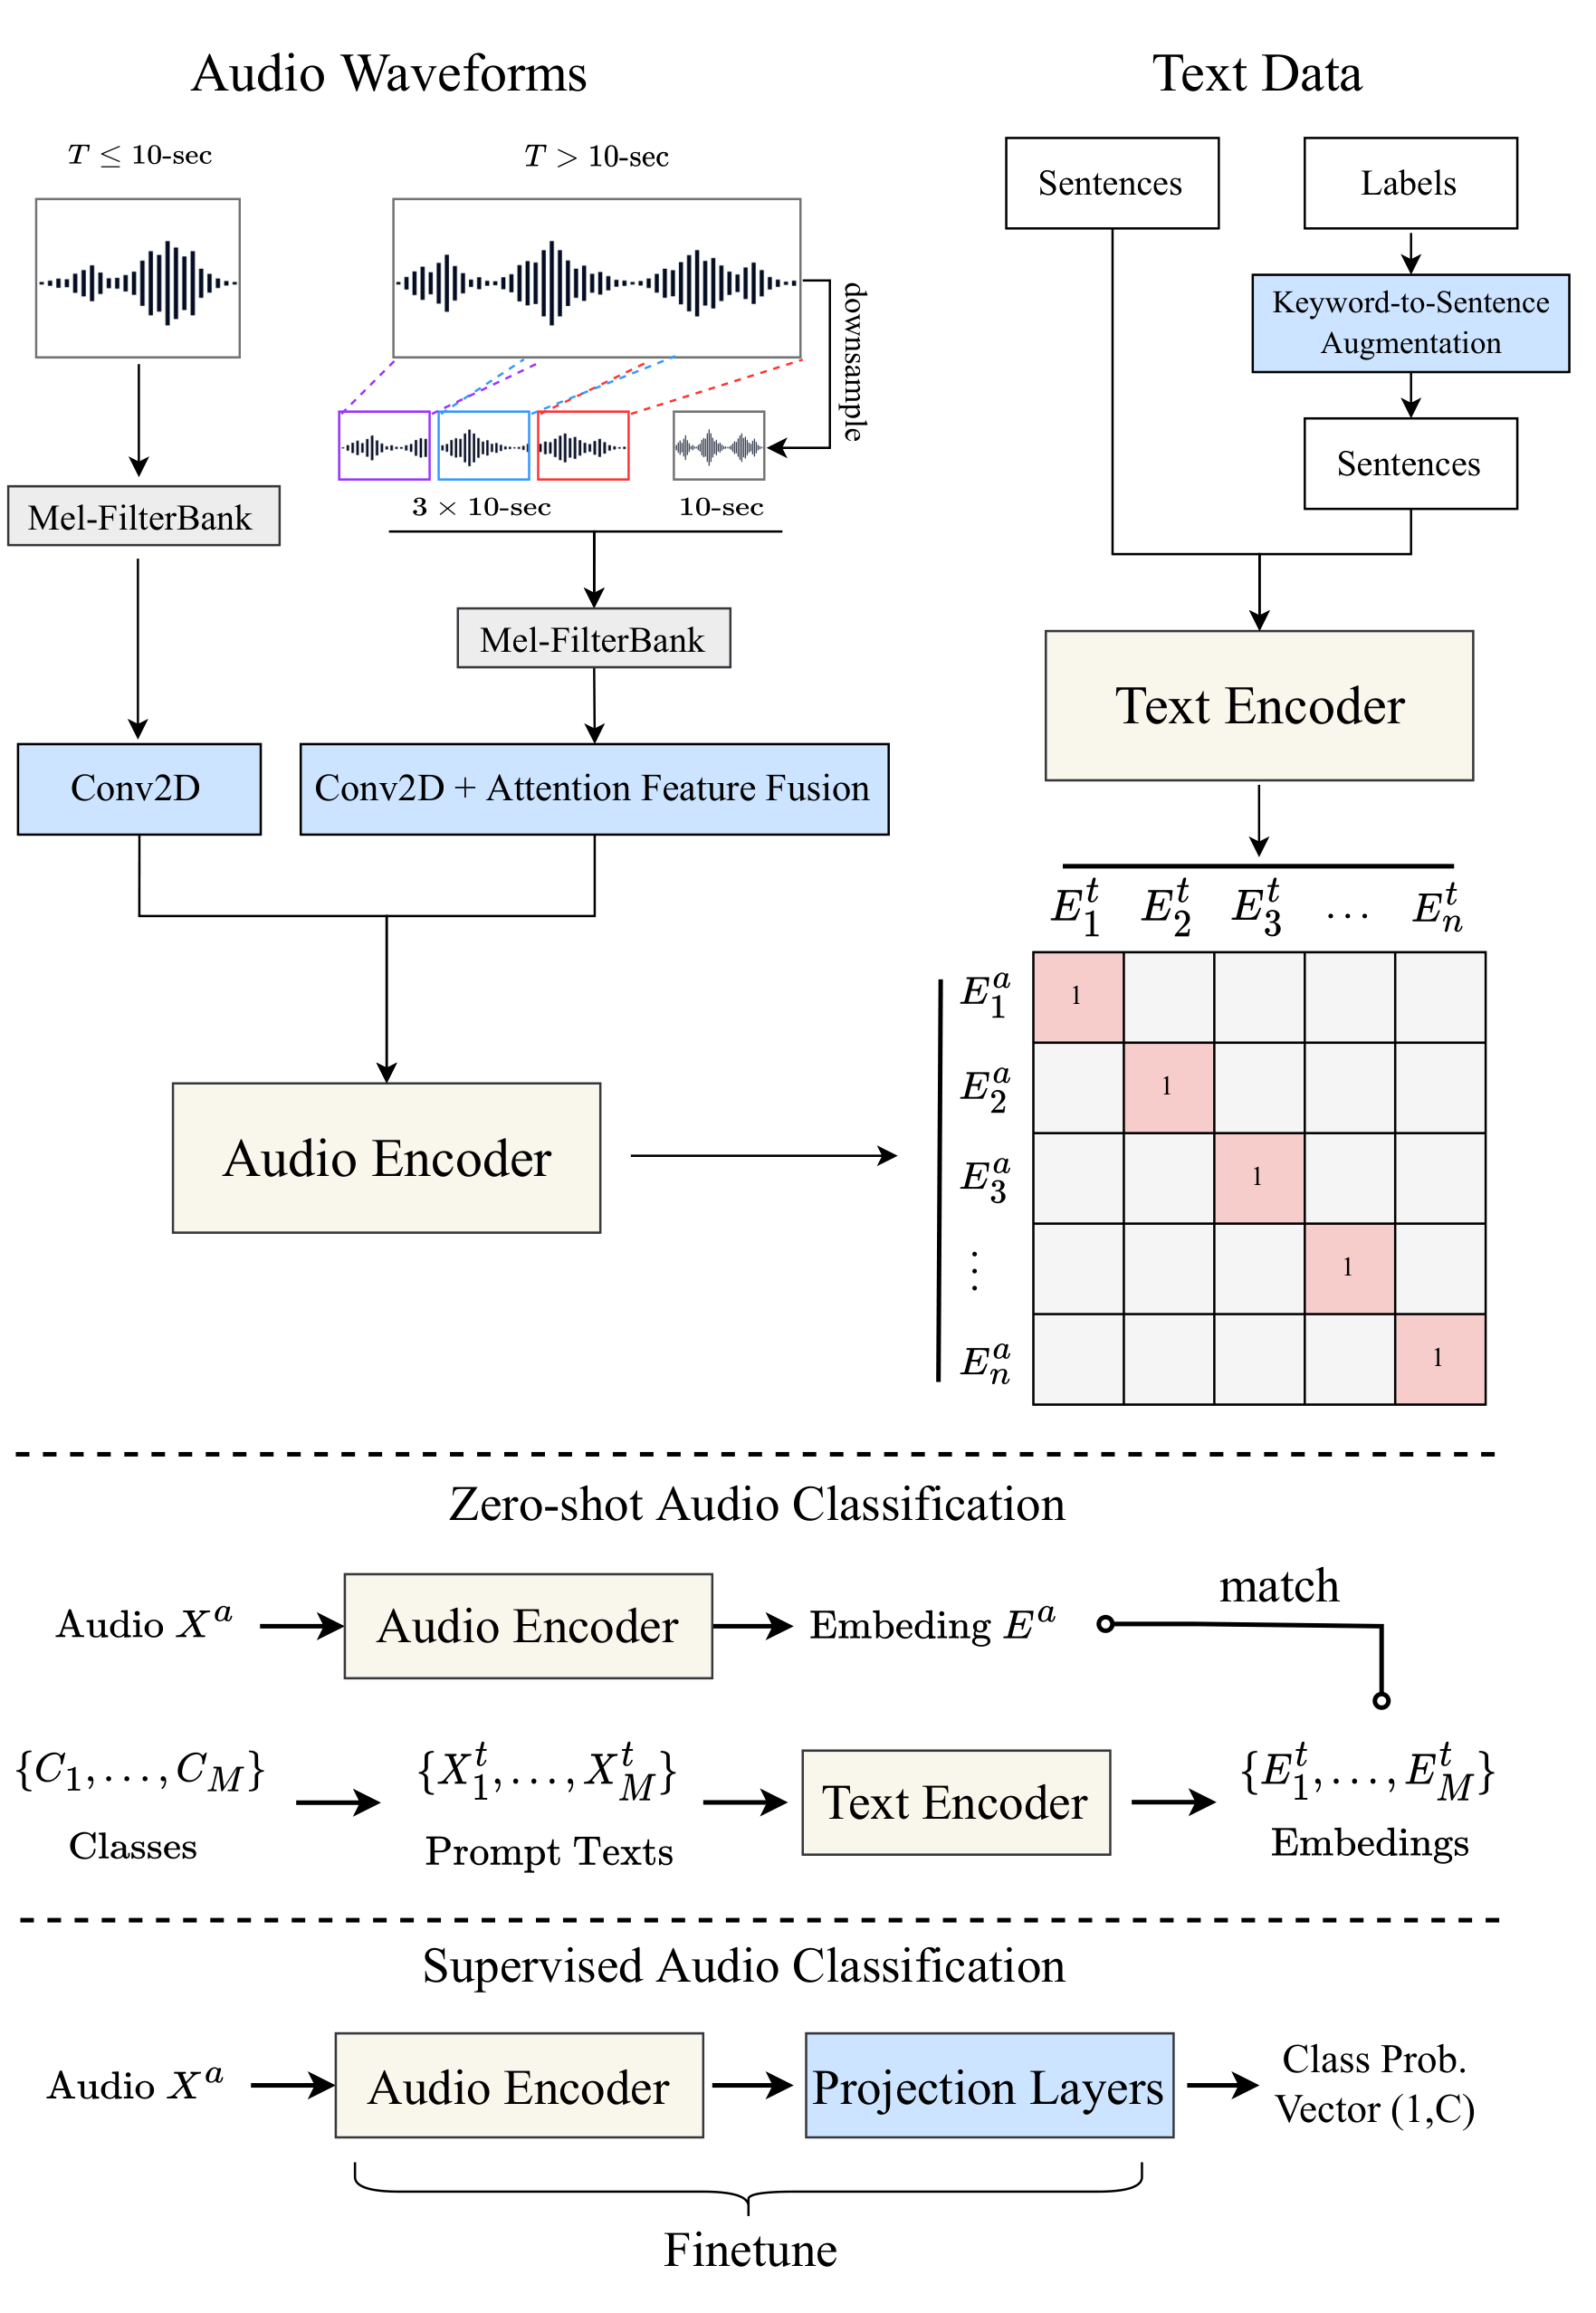
https://arxiv.org/pdf/2211.06687

### Objective of This Notebook

We aim to experiment with **few-shot learning** to distinguish between **cat** and **dog** audio clips using CLAP embeddings.

Key steps:
- Prepare a small, labeled dataset of cat/dog sounds.
- Extract embeddings using CLAP.
- train with different trainig mode: `binary`, `classifier`, `lora`, `contrastive`
- Evaluate and visualize model performance.

## Training Workflow

#### 1. Import requirements

In [1]:
import os
import random
import pickle
import pathlib
import math
import numpy as np
import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import ClapProcessor, ClapModel
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import pytorch_lightning as pl

pl.seed_everything(42)

Seed set to 42


42

#### 2. Configure the Experiment

Set up the core parameters that control how the experiment is run:

- **`data_dir`**: Path to the directory containing your dataset.
- **`few_shot_per_class`**: Number of training samples to use per class (e.g., cat or dog).
- **`batch_size`**: Number of samples in each training batch.
- **`epochs`**: Total number of times the model will iterate over the training dataset.
- **`lr`** *(learning rate)*: Set to `1e-4` by default. Consider reducing this if training becomes unstable.
- **`train_mode`**: Choose from the following training strategies:
- **`fewshot_binary`**: Train a linear classifier on top of pretrained CLAP embeddings using binary cross-entropy.
- **`fewshot_classifier`**: Use text captions (e.g., "the sound of a cat") with cosine similarity for classification (inspired by Section 3.2 of the CLAP paper, though not zero-shot here).
- **`lora`**: Fine-tune the CLAP encoder using LoRA adapters with the same binary classification setup as `fewshot_binary`.
- **`TODO:contrastive`** : Use contrastive losses for negative/positive samples.

In [2]:
CONFIG = {
    "data_dir": "data/cat_dog_audio",
    "few_shot_per_class": 5,
    "batch_size": 4,
    "epochs": 10,
    "lr": 1e-4,
    "train_mode": "fewshot_classifier",
}
print(CONFIG)

{'data_dir': 'data/cat_dog_audio', 'few_shot_per_class': 5, 'batch_size': 4, 'epochs': 10, 'lr': 0.0001, 'train_mode': 'fewshot_classifier'}


#### 3. Download the data and define the dataset class

In [3]:
def download_kaggle(dest):
    if dest.exists() and list(dest.rglob("*.wav")):
        return
    dest.mkdir(parents=True, exist_ok=True)
    os.system(f"kaggle datasets download -d mmoreaux/audio-cats-and-dogs -p {dest} --unzip")


class CatDog(Dataset):
    def __init__(self, paths, proc):
        self.paths = paths
        self.proc = proc
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, i):
        wav, sr = torchaudio.load(str(self.paths[i]))
        if sr != 48000:
            wav = torchaudio.functional.resample(wav, sr, 48000)
        wav = wav.mean(0)
        x = self.proc(audios=wav, sampling_rate=48000, return_tensors="pt")
        x = {k: v.squeeze(0) for k, v in x.items()}
        x["labels"] = torch.tensor(0 if self.paths[i].parent.name.startswith("cat") else 1)
        return x


def build_loaders():
    wavs = sorted(Path(CONFIG["data_dir"]).rglob("*.wav"))
    y = [0 if p.parent.name.startswith("cat") else 1 for p in wavs]
    tr, te = train_test_split(range(len(wavs)), test_size=0.3, stratify=y, random_state=42)
    keep = []
    cnt = {0: 0, 1: 0}
    for i in tr:
        if cnt[y[i]] < CONFIG["few_shot_per_class"]:
            keep.append(i)
            cnt[y[i]] += 1
    va, _ = train_test_split(
        [i for i in tr if i not in keep],
        test_size=0.5,
        stratify=[y[i] for i in tr if i not in keep],
        random_state=43
    )
    proc = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
    
    def coll(b):
        out = {k: torch.stack([d[k] for d in b]) for k in b[0] if k != "labels"}
        out["labels"] = torch.tensor([d["labels"] for d in b])
        return out
    
    loaders = {}
    for split, idx in [("train", keep), ("val", va), ("test", te)]:
        loaders[split] = DataLoader(
            CatDog([wavs[i] for i in idx], proc),
            batch_size=CONFIG["batch_size"],
            shuffle=(split == "train"),
            collate_fn=coll
        )
    return loaders, proc

#### 4. Custom model factory functions that load the appropriate models depending on config setting.

In [4]:
def count_parameters(model):
    """Helper function to properly count parameters"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

def make_model(mode: str, device: torch.device):
    """
    Build CLAP-based model with proper parameter management
    """
    print(f"Initializing model for mode: {mode}")
    
    # Load fresh CLAP model
    base = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
    proj_dim = base.config.projection_dim
    
    # Check initial parameter counts
    total_params, _, _ = count_parameters(base)
    print(f"Initial CLAP model has {total_params:,} parameters")

    if mode == "fewshot_binary":
        # Freeze ALL CLAP parameters
        for param in base.parameters():
            param.requires_grad = False
            
        # Create simple linear classifier
        head = nn.Linear(proj_dim, 2).to(device)
        
        # Verify freezing worked
        total, trainable, frozen = count_parameters(base)
        head_params = sum(p.numel() for p in head.parameters())
        
        print(f"  CLAP frozen params: {frozen:,}")
        print(f"  CLAP trainable params: {trainable:,}")
        print(f"  Head trainable params: {head_params:,}")
        
        optimizer = torch.optim.AdamW(head.parameters(), lr=CONFIG["lr"])

    elif mode == "fewshot_classifier":
        # Freeze ALL CLAP parameters
        for param in base.parameters():
            param.requires_grad = False
            
        # Create projection layer (learnable transformation of audio embeddings)
        head = nn.Linear(proj_dim, proj_dim, bias=False).to(device)
        # Initialize as identity to preserve CLAP geometry
        with torch.no_grad():
            head.weight.copy_(torch.eye(proj_dim))
        
        # Verify freezing
        total, trainable, frozen = count_parameters(base)
        head_params = sum(p.numel() for p in head.parameters())
        
        print(f"  CLAP frozen params: {frozen:,}")
        print(f"  CLAP trainable params: {trainable:,}")
        print(f"  Projection trainable params: {head_params:,}")
        
        optimizer = torch.optim.AdamW(head.parameters(), lr=CONFIG["lr"])

    elif mode == "lora":
        # First freeze everything
        for param in base.parameters():
            param.requires_grad = False
            
        # Apply LoRA - try broader target modules for better coverage
        lora_config = LoraConfig(
            r=16,  # Increased rank for potentially better performance
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            target_modules=[
                # Common transformer layer names
                "query", "key", "value", "dense",
                "q_proj", "k_proj", "v_proj", "out_proj",
                "fc1", "fc2", "c_fc", "c_proj",
                # Audio-specific layers that might exist
                "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.out_proj"
            ]
        )
        
        try:
            base = get_peft_model(base, lora_config)
            print(f"  Successfully applied LoRA to model")
        except Exception as e:
            print(f"  LoRA application warning: {e}")
            # If specific modules not found, try with basic modules
            lora_config.target_modules = ["query", "key", "value", "dense"]
            base = get_peft_model(base, lora_config)
        
        # Ensure text encoder stays frozen (extra safety)
        for name, param in base.named_parameters():
            if "text_model" in name or "text_projection" in name:
                param.requires_grad = False
        
        # Create classification head
        head = nn.Linear(proj_dim, 2).to(device)
        
        # Count parameters after LoRA
        total, trainable_base, frozen_base = count_parameters(base)
        head_params = sum(p.numel() for p in head.parameters())
        
        print(f"  Total CLAP params: {total:,}")
        print(f"  CLAP trainable (LoRA) params: {trainable_base:,}")
        print(f"  CLAP frozen params: {frozen_base:,}")
        print(f"  Head trainable params: {head_params:,}")
        
        # Optimizer includes LoRA parameters + head
        trainable_params = [p for p in base.parameters() if p.requires_grad] + list(head.parameters())
        optimizer = torch.optim.AdamW(trainable_params, lr=CONFIG["lr"])
        
    else:
        raise ValueError(f"Unknown mode: {mode}")

    return base, head, optimizer


def prepare_text_embeddings(base_model, processor, device, labels_txt):
    """Prepare text embeddings for classification"""
    base_model.eval()
    with torch.no_grad():
        text_inputs = processor(
            text=[f"the sound of a {label}" for label in labels_txt],
            return_tensors="pt"
        ).to(device)
        
        text_emb = base_model.get_text_features(**text_inputs)
        text_emb = F.normalize(text_emb, dim=-1)
    return text_emb

#### 5. Few-shot training

In [5]:
def run_epoch(loader, base_model, clf_head, optimizer, text_embeddings, train_mode, device, train=True):
    """Training/validation epoch with proper gradient handling"""
    if train and train_mode=='lora':
        base_model.train()
        if clf_head is not None:
            clf_head.train()
    
    # elif train and train_mode=='fewshot_classifier':
    #     base_model.eval()
    #     if clf_head is not None:
    #         clf_head.train()
    else:
        base_model.eval()
        if clf_head is not None:
            clf_head.train()

    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.set_grad_enabled(train):
        for batch in loader:
            labels = batch.pop("labels").to(device)
            audio_inputs = {k: v.to(device) for k, v in batch.items() 
                          if k in {"input_features", "attention_mask"}}

            # Forward pass through CLAP audio encoder
            audio_features = base_model.get_audio_features(**audio_inputs)
            audio_features = F.normalize(audio_features, dim=-1)  # L2 normalize

            if train_mode == "fewshot_binary":
                # Simple linear classification on frozen CLAP features
                logits = clf_head(audio_features)
                
            elif train_mode == "fewshot_classifier":
                # Project audio features and compare with text embeddings
                projected_features = clf_head(audio_features)
                projected_features = F.normalize(projected_features, dim=-1)
                
                # Compute cosine similarity as logits (scaled for better gradients)
                logits = 10.0 * (projected_features @ text_embeddings.T)
                
            elif train_mode == "lora":
                # Use LoRA adapted features with linear classifier
                logits = clf_head(audio_features)
            
            else:
                raise ValueError(f"Unknown train_mode: {train_mode}")

            # Compute loss
            loss = F.cross_entropy(logits, labels)
            
            if train:
                optimizer.zero_grad()
                loss.backward()
                
                # Gradient clipping for stability
                if clf_head is not None:
                    torch.nn.utils.clip_grad_norm_(clf_head.parameters(), max_norm=1.0)
                if train_mode == "lora":
                    # Clip LoRA parameters too
                    trainable_params = [p for p in base_model.parameters() if p.requires_grad]
                    if trainable_params:
                        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
                
                optimizer.step()

            # Collect predictions and labels
            running_loss += loss.item() * labels.size(0)
            predictions = logits.argmax(dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    avg_loss = running_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    
    return avg_loss, accuracy, cm

#### 6. Run full training pipeline + Test-set evaluation + logging

In [6]:
def run_complete_pipeline(train_mode, loaders, processor, device, config):
    """Complete pipeline with improved training"""
    print(f"\n{'='*60}")
    print(f"Running {train_mode.upper()}")
    print(f"{'='*60}")
    
    # Initialize model
    base_model, clf_head, optimizer = make_model(train_mode, device)
    
    # Prepare text embeddings
    labels_txt = ["cat", "dog"]
    text_embeddings = prepare_text_embeddings(base_model, processor, device, labels_txt)
    
    # Training setup
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_epoch = 0
    
    # Adjust epochs based on mode
    epochs = config["epochs"]
    if train_mode == "fewshot_binary":
        epochs = min(epochs, 20)  # May need more epochs for simple linear layer
    
    print(f"Training for {epochs} epochs with learning rate {config['lr']}")
    print(f"Train samples: {len(loaders['train'].dataset)}")
    print(f"Val samples: {len(loaders['val'].dataset)}")
    print()
    
    for epoch in range(epochs):
        # Training
        train_loss, train_acc, _ = run_epoch(
            loaders["train"], base_model, clf_head, optimizer, 
            text_embeddings, train_mode, device, train=True
        )
        
        # Validation
        val_loss, val_acc, val_cm = run_epoch(
            loaders["val"], base_model, clf_head, optimizer, 
            text_embeddings, train_mode, device, train=False
        )
        
        # Track metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train: Loss={train_loss:.3f}, Acc={train_acc:.3f} | "
              f"Val: Loss={val_loss:.3f}, Acc={val_acc:.3f}")
        
        # Early stopping check
        if epoch - best_epoch > 5 and epoch > 10:  # Stop if no improvement for 5 epochs
            print(f"Early stopping at epoch {epoch+1} (best was epoch {best_epoch+1})")
            break
    
    # Final test evaluation
    print(f"\nEvaluating on test set...")
    test_loss, test_acc, test_cm = run_epoch(
        loaders["test"], base_model, clf_head, optimizer, 
        text_embeddings, train_mode, device, train=False
    )
    
    # Detailed test metrics
    test_preds, test_labels = [], []
    base_model.eval()
    if clf_head:
        clf_head.eval()
    
    with torch.no_grad():
        for batch in loaders["test"]:
            labels = batch.pop("labels").to(device)
            audio_inputs = {k: v.to(device) for k, v in batch.items() 
                          if k in {"input_features", "attention_mask"}}
            
            audio_features = F.normalize(base_model.get_audio_features(**audio_inputs), dim=-1)
            
            if train_mode == "fewshot_binary":
                logits = clf_head(audio_features)
            elif train_mode == "fewshot_classifier":
                projected = F.normalize(clf_head(audio_features), dim=-1)
                logits = 10.0 * (projected @ text_embeddings.T)
            elif train_mode == "lora":
                logits = clf_head(audio_features)
                
            test_preds.extend(logits.argmax(1).cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
    
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    
    print(f"Final Results:")
    print(f"  Best Val Acc: {best_val_acc:.3f} (epoch {best_epoch+1})")
    print(f"  Test Acc: {test_acc:.3f}")
    print(f"  Test F1: {test_f1:.3f}")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_cm': test_cm,
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch
    }

#### 7. Launch module

Dataset sizes: {'train': 10, 'val': 188, 'test': 167}
Using device: cuda

Running FEWSHOT_BINARY
Initializing model for mode: fewshot_binary
Initial CLAP model has 153,492,890 parameters
  CLAP frozen params: 153,492,890
  CLAP trainable params: 0
  Head trainable params: 1,026
Training for 10 epochs with learning rate 0.0001
Train samples: 10
Val samples: 188

Epoch  1/10 | Train: Loss=0.689, Acc=0.500 | Val: Loss=0.679, Acc=0.798
Epoch  2/10 | Train: Loss=0.688, Acc=0.500 | Val: Loss=0.679, Acc=0.798
Epoch  3/10 | Train: Loss=0.686, Acc=0.500 | Val: Loss=0.678, Acc=0.803
Epoch  4/10 | Train: Loss=0.685, Acc=0.500 | Val: Loss=0.678, Acc=0.803
Epoch  5/10 | Train: Loss=0.684, Acc=0.600 | Val: Loss=0.678, Acc=0.803
Epoch  6/10 | Train: Loss=0.681, Acc=0.600 | Val: Loss=0.677, Acc=0.809
Epoch  7/10 | Train: Loss=0.680, Acc=0.600 | Val: Loss=0.677, Acc=0.798
Epoch  8/10 | Train: Loss=0.677, Acc=0.600 | Val: Loss=0.676, Acc=0.787
Epoch  9/10 | Train: Loss=0.677, Acc=0.600 | Val: Loss=0.675

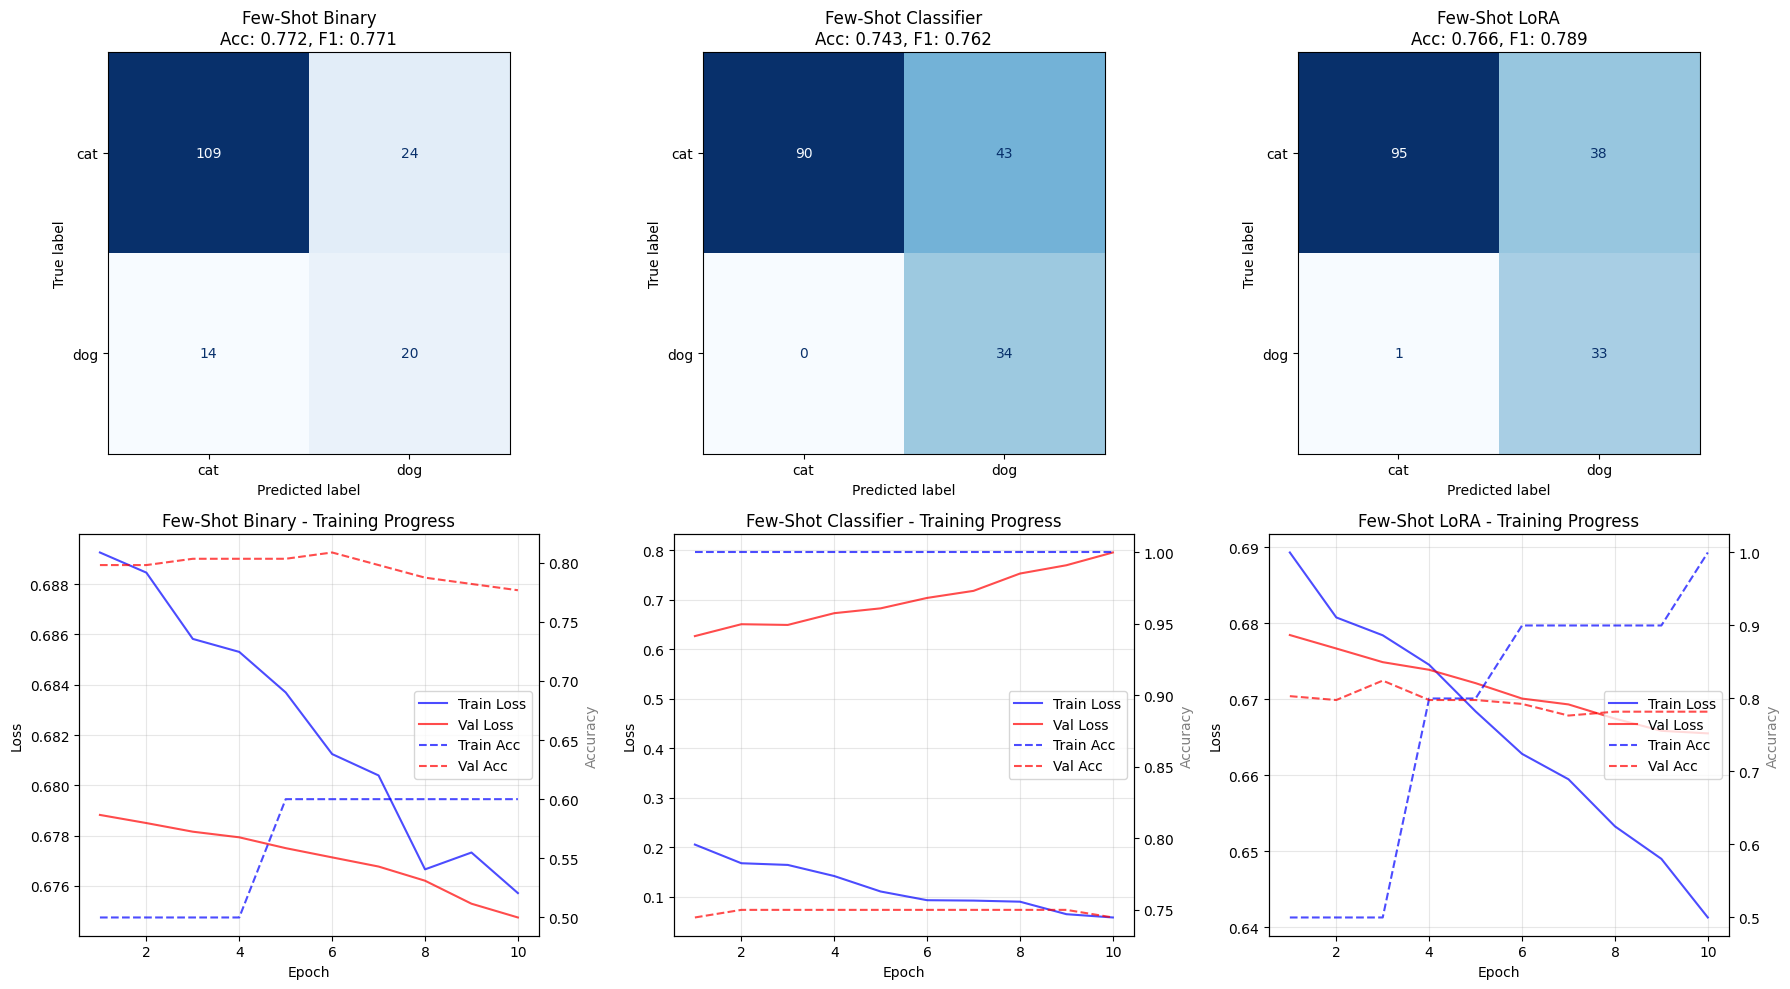

In [7]:
def main():
    # Setup
    download_kaggle(Path(CONFIG["data_dir"]))
    data_loaders, proc = build_loaders()
    print("Dataset sizes:", {k: len(v.dataset) for k, v in data_loaders.items()})

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Run experiments
    train_modes = ["fewshot_binary", "fewshot_classifier", "lora"]
    all_results = {}

    for mode in train_modes:
        current_config = CONFIG.copy()
        current_config["train_mode"] = mode
        
        try:
            results = run_complete_pipeline(mode, data_loaders, proc, device, current_config)
            all_results[mode] = results
        except Exception as e:
            print(f"Error in {mode}: {e}")
            import traceback
            traceback.print_exc()

    # Results visualization and summary
    if all_results:
        print(f"\n{'='*80}")
        print("EXPERIMENT SUMMARY")
        print(f"{'='*80}")
        
        for mode, results in all_results.items():
            print(f"{mode.upper():>20}: Test Acc={results['test_acc']:.3f}, "
                    f"Test F1={results['test_f1']:.3f}, "
                    f"Best Val={results['best_val_acc']:.3f}")
        
        # Create comparison plot
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))
        
        mode_names = {
            "fewshot_binary": "Few-Shot Binary",
            "fewshot_classifier": "Few-Shot Classifier", 
            "lora": "Few-Shot LoRA"
        }
        
        # Confusion matrices
        for i, (mode, results) in enumerate(all_results.items()):
            ax = [ax1, ax2, ax3][i]
            cm = results['test_cm']
            acc = results['test_acc']
            f1 = results['test_f1']
            
            ConfusionMatrixDisplay(cm, display_labels=["cat", "dog"]).plot(
                cmap="Blues", ax=ax, colorbar=False
            )
            ax.set_title(f"{mode_names[mode]}\nAcc: {acc:.3f}, F1: {f1:.3f}")
        
        # Training curves
        for i, (mode, results) in enumerate(all_results.items()):
            ax = [ax4, ax5, ax6][i]
            epochs = range(1, len(results['train_losses']) + 1)
            
            ax.plot(epochs, results['train_losses'], 'b-', label='Train Loss', alpha=0.7)
            ax.plot(epochs, results['val_losses'], 'r-', label='Val Loss', alpha=0.7)
            
            ax2 = ax.twinx()
            ax2.plot(epochs, results['train_accs'], 'b--', label='Train Acc', alpha=0.7)
            ax2.plot(epochs, results['val_accs'], 'r--', label='Val Acc', alpha=0.7)
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss', color='black')
            ax2.set_ylabel('Accuracy', color='gray')
            ax.set_title(f"{mode_names[mode]} - Training Progress")
            
            # Combine legends
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='center right')
            
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

main()

#### Discussion

- **FewShot Binary**  
  - Predicts almost all samples as “cat.”  
  - Improvement could be done by regularization. 

- **FewShot Classifier** 
  - The model is overfitting. Using a dot-product for feature and text embedding + CE head on only 5 samples/class easily overfits to those prototypes  
  - Instead of computing similarity and then using cross-entropy loss, a better approach would be to use contrastive loss on pairs of cat/dog samples.

- **FewShot LoRA**  
  - Generalizes better and has a smaller train/validation gap.  
  - Finding the optimal number of top k ranks would further improve the model.

#### Future Work

- Resample with higher rate
- Increase shots (10 instead of 5).  
- Explore contrastive learning with fewshot learning.
- Exploring with other foundation models
